In [1]:
# final project
# "seamless social media collage creator"
# jazib waqar raza
# goal: make an aesthetic collage tool for 4 or 6 photos

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

Loaded 6 images: ['imgB_3.jpg', 'imgA_1.png', 'imgB_2.jpg', 'imgB_7.jpg', 'imgB_4.jpg', 'imgA_14.jpg']


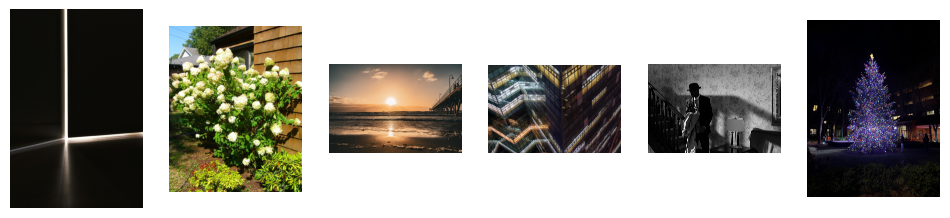

In [3]:
#part i) image loading
#purpose: load 4–6 random images from the dataset folder for collage generation

#setting up the input & output directory paths and make sure its in place
DATASET_DIR = "./Images"
OUT_DIR = "./Outputs"
os.makedirs(OUT_DIR, exist_ok=True)


all_files = [f for f in os.listdir(DATASET_DIR) if f.lower().endswith(('.jpg','.png','.jpeg'))]
#listing all valid image types from dataset folder to be collected

selected = random.sample(all_files, random.choice([4,6]))
#a random choice between selected either 4 or 6 images from dataset to be used

images = [cv2.imread(os.path.join(DATASET_DIR, f)) for f in selected]
#reading the selected images and storing them in list 'images'
print(f"Loaded {len(images)} images:", selected)
#providing names of image selected for reference just in case


plt.figure(figsize=(12,4))
#for statement to iterate amongst the image list
for i, img in enumerate(images):
    plt.subplot(1,len(images),i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()
#using matplotlib to display the loaded images
#color conversion to rgb to display correct output
#all in single row

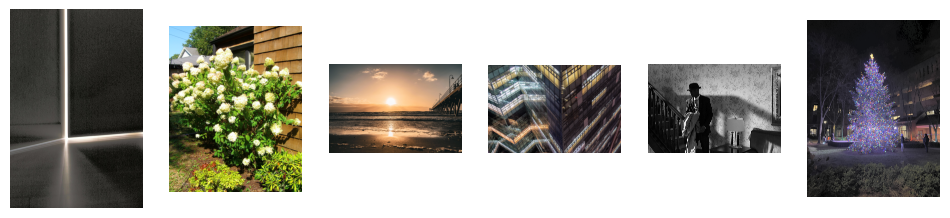

In [4]:
#part ii) tone harmonization
#purpose: gently equalize global tone using a custom CDF on luminance channel

#helper function to create custom histogram equalization
def custom_hist_eq(channel):
    
    #mapping out histogram over full 0-255 range
    hist, bins = np.histogram(channel.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    
    #masking out 0 counts to prevent issues when normalizing
    cdf_masked = np.ma.masked_equal(cdf, 0)
    
    # normalize the masked CDF to the range 0-255
    cdf_norm = (cdf_masked - cdf_masked.min()) * 255 / (cdf_masked.max() - cdf_masked.min())
    
    #filling masked values with zero and converting to uin8 form to lookup
    cdf_final = np.ma.filled(cdf_norm, 0).astype("uint8")
    #apply the lookup table to the current channel
    return cdf_final[channel]

#list to carry all tone equalized images
images_tone = []

for img in images:
    # convert into YUV format to isolate the luminance channel
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

    #splitting the channel into respective variable
    y, u, v = cv2.split(yuv)

    #run custom equalization on the Y (luminance channel)
    y_eq = custom_hist_eq(y)

    #blending the original + equalized output with cv2.addWeighted
    y_soft = cv2.addWeighted(y, 0.7, y_eq, 0.3, 0)

    #merge the new luminance channel into other YUL values
    merged = cv2.merge([y_soft, u, v])
    #convert YUL back into BGR to display the new enhanced output
    out_img = cv2.cvtColor(merged, cv2.COLOR_YUV2BGR)

    #appends to the equalized image list
    images_tone.append(out_img)


plt.figure(figsize=(12,4))
#for statement to iterate amongst the image list
for i, img in enumerate(images_tone):
    plt.subplot(1, len(images_tone), i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()
#using matplotlib to display the loaded images
#color conversion to rgb to display correct output
#all in single row

In [ ]:
#part iii) edge + line detection
#purpose: detect and visualize dominant lines (horizontal & vertical) for alignment

def detect_and_visualize_lines(img):

    #convert to greyscale for easy edge processing
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #a soft gaussian blur to alleviate noise before Canny process
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    #detect the edges in image with defined params
    edges = cv2.Canny(blur, 50, 150)
    #probabilistic hough to use the Canny output to attain straight line segments
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=60, minLineLength=80, maxLineGap=20)

    #convert edges into bgr to showcase clear in colored form
    vis = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)

    #list created to carry the average angles detected from edges
    angles = []

    #if statement to begin in case no lines detected
    if lines is not None:

        #going over coordinates of line segments
        for x1,y1,x2,y2 in lines[:,0]:
            #draw the lines in green to display detected elements
            cv2.line(vis, (x1,y1), (x2,y2), (0,255,0), 2)

            #computing the angle in degrees via numpy methods
            angle = np.degrees(np.arctan2(y2-y1, x2-x1))

            #filter out angles in horizontal spheres only for easy processing
            if abs(angle) < 45:
                #append angle to angle list
                angles.append(angle)

    #obtain the aggregate angle by taking the average across image or 0 in case none
    angle = np.median(angles) if angles else 0.0

    #return the obtained visible edges and angles
    return angle, vis


#angle and edge outputs for all images used
angles, visual_edges = [], []

#iterate over the equalized image list and detect angles with function
for img in images_tone:
    a, vis = detect_and_visualize_lines(img)
    #append the respective outputs to desired list
    angles.append(a)
    visual_edges.append(vis)

print("Detected angles:", angles)
#illustrate the output of angles attained

plt.figure(figsize=(12,4))
#for statement to iterate amongst the edge  image list
for i, vis in enumerate(visual_edges):
    plt.subplot(1, len(visual_edges), i+1)
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()
#using matplotlib to display the loaded images
#color conversion to rgb to display correct output
#all in single row

In [ ]:
#part iv) alignment (rotation + leveling)
#purpose: align each image based on its horizon to ensure geometric harmony

def align_image(img, angle):

    #attaining the height & width for rotation center
    h,w = img.shape[:2]

    #making rotation matrix via negative angle to tilt
    M = cv2.getRotationMatrix2D((w//2, h//2), -angle, 1.0)

    #applying the rotation with cubic interpolation and reflected borders to ensure filment
    return cv2.warpAffine(img, M, (w,h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REFLECT)

#obtaining the average angle across all images to be used as reference
median_angle = np.median(angles)
#images aligned with respect to the shared median to allow for coherent output
images_aligned = [align_image(img, a - median_angle) for img,a in zip(images_tone, angles)]

plt.figure(figsize=(12,4))
#for statement to iterate amongst the transformed image list
for i,img in enumerate(images_aligned):
    plt.subplot(1,len(images_aligned),i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()
#using matplotlib to display the loaded images
#color conversion to rgb to display correct output
#all in single row

In [ ]:
#part v) cropping (post-alignment)
#purpose: crop aligned images to portrait cell sizes for vertical collage layout

def crop_to_cell(img, target_w, target_h):
    h, w = img.shape[:2]
    #attaining the height & width for cropping reference

    #scale to ensure that final image covers target cell completely
    scale = max(target_w / w, target_h / h)
    #resizing image whilst preserving image ratio
    resized = cv2.resize(img, (int(w * scale), int(h * scale)))
    #new dimensions after resizing
    h, w = resized.shape[:2]

    #center-cropping coordinates to frame cleanly
    x = (w - target_w) // 2
    y = (h - target_h) // 2

    #return the final crop
    return resized[y:y + target_h, x:x + target_w]
    
#layout to determine what formal based on 4 or 6 image cases
layout = len(images_aligned)

#if statement to handle cases for 4 or 6
if layout == 4:
    #if 4 each crop will have dimensions 540x960 with 2x2 collage form
    cell_w, cell_h, rows, cols = 540, 960, 2, 2
else:
    #if 6 each crop will have dimensions 540x640 with 2x3 collage form
    cell_w, cell_h, rows, cols = 540, 640, 3, 2

#applying the cropping function to each aligned image
images_cropped = [crop_to_cell(img, cell_w, cell_h) for img in images_aligned]

plt.figure(figsize=(12,4))
#for statement to iterate amongst the transformed image list
for i, img in enumerate(images_cropped):
    plt.subplot(1, len(images_cropped), i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
plt.show()
#using matplotlib to display the loaded images
#color conversion to rgb to display correct output
#all in single row


In [ ]:
#part vi) collage assembly (portrait orientation)
#purpose: stack cropped images top-to-bottom into a 1080x1920 story-style collage

def assemble_grid_vertical(imgs, rows, cols, cell_w, cell_h):

    #initializing blank grid to fill with each portrait cell
    grid = np.zeros((rows * cell_h, cols * cell_w, 3), dtype=np.uint8)

    #index to keep track of image count
    index = 0
    #iterate based on image coordinate to be filled
    for r in range(rows):
        for c in range(cols):
            if index < len(imgs):
                #computing coordinates for the current cell
                y1, y2 = r * cell_h, (r + 1) * cell_h
                x1, x2 = c * cell_w, (c + 1) * cell_w

                #place the image into the target cell
                grid[y1:y2, x1:x2] = imgs[index]
                
                #increment index to next image
                index += 1
    #return the assembled collage image
    return grid

#calling the collage function and storing raw output to respective variable
collage_raw = assemble_grid_vertical(images_cropped, rows, cols, cell_w, cell_h)

plt.figure(figsize=(6,10))
plt.imshow(cv2.cvtColor(collage_raw, cv2.COLOR_BGR2RGB))
plt.title("Raw Collage, Pre-Blending Stage")
plt.axis('off')
plt.show()
#using matplotlib to display the loaded images
#color conversion to rgb to display correct output

In [ ]:
#part vii) feather blending
#purpose: smooth horizontal and vertical seams in the fixed grid for seamless look

#function with bw parameter to set boundary blend width
def blend_seams(collage, rows, cols, cell_w, cell_h, bw=10):

    #converting raw collage into float type for blending procedures
    blend = collage.astype(np.float32)
    
    # vertical seams
    #remains same for either 4 or 6 image (2 images spanned)
    for c in range(1, cols):
        
        x = c * cell_w
        alpha = np.linspace(0, 1, bw, dtype=np.float32)[None, :, None]
        #creating a left to right gradient for blending
        
        #extract small strips based on the blend width on seams
        left = blend[:, x - bw:x, :].copy()
        right = blend[:, x:x + bw, :].copy()

        #applys feather blend across the vertical transition
        blend[:, x - bw:x, :] = left * (1 - alpha) + right * alpha
    
    # horizontal seams
    #differs for 4 and 6 image
    #for 4 images it occurs once (as 2 images spanned)
    #for 6 images it occurs twice (as 3 images spanned)
    for r in range(1, rows):
        
        y = r * cell_h
        alpha = np.linspace(0, 1, bw, dtype=np.float32)[:, None, None]
        #creating a top to bottom gradient for blending

        #extracting small strips based on the blend width set
        top = blend[y - bw:y, :, :].copy()
        bottom = blend[y:y + bw, :, :].copy()

        #applying feather blends across the horizontal image boundaries
        blend[y - bw:y, :, :] = top * (1 - alpha) + bottom * alpha
    
    return np.clip(blend, 0, 255).astype(np.uint8)
    #clip the values and then convert into uint8 for final output form

#calls the blending function on raw collage for a blended output
collage_blend = blend_seams(collage_raw, rows, cols, cell_w, cell_h)

plt.figure(figsize=(6, 10))
plt.imshow(cv2.cvtColor(collage_blend, cv2.COLOR_BGR2RGB))
plt.title("Final Collage with Feather Blending")
plt.axis('off')
plt.show()
#using matplotlib to display the loaded images
#color conversion to rgb to display correct output

In [ ]:
#part viii) output saving
#purpose: export final 1080x1920 collage to output directory

#utilize the output directory path and write the end result
output_path = os.path.join(OUT_DIR, "final_collage.jpg")
cv2.imwrite(output_path, collage_blend)
#printed confirmation of completed output procedure
print("Final collage saved at:", output_path)
